In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import kwant
import tinyarray

In [3]:
def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:
    
        if ans < 0: return 2*np.pi + ans
        else: return ans
    
    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans
    
    else: raise TypeError("atan is getting neither floats nor arrays")

# define graphene lattices
def create_graphene_hexagonal_system(r, start = 0, a = 1.0, t_prime=0.0, norb = 1, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 6, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            else: y += 1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = 0 # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = 1.0
    if not np.allclose(t_prime, 0):
        sys[lat.neighbors(n=2)] = t_prime
    
    # Choose a specific site

    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1: del sys[s]
    # make sure that no lattice point is connected to more than one site
    return sys

def create_graphene_tiangular_system(r, start = 0, t_prime = 0.0, a = 1.0, norb = 1, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 3, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = 0 # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = 1.0
    if not np.allclose(t_prime, 0):
        sys[lat.neighbors(n=2)] = t_prime
    
    # Choose a specific site

    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    # make sure that no lattice point is connected to more than one site
    return sys

def create_graphene_circular_system(r, a=1.0, norb=1, t_prime = 0.0):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    sys = kwant.Builder()
    sys[lat.shape(lambda pos: np.linalg.norm(np.array([*pos])) < r, (0, 0))] = 0
    sys[lat.neighbors(n=1)] = 1
    if not np.allclose(t_prime, 0):
        sys[lat.neighbors(n=2)] = t_prime

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    return sys

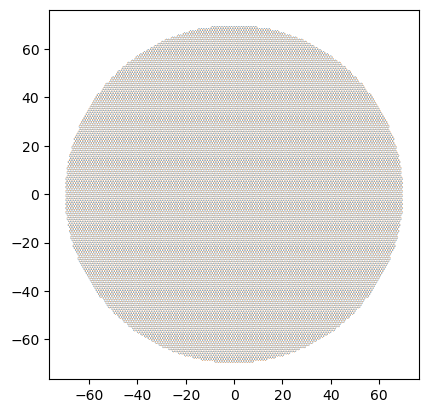

In [69]:
circular_dot = create_graphene_circular_system(r=70.)
hexa_dot = create_graphene_hexagonal_system(r=15.)
tri_dot = create_graphene_tiangular_system(r=15., start=np.pi/2)
kwant.plot(circular_dot)
plt.show()

In [72]:
gqd = circular_dot.finalized()
N = len(gqd.sites)

In [73]:
N

35437

In [83]:
h = gqd.hamiltonian_submatrix(sparse=True)
X = np.random.rand(h.shape[0], 200)  # Initial guess for eigenvectors

energies, states = sla.lobpcg(h@h, X, largest=False, maxiter=400)
# energies, states = sla.eigsh(h.tocsc(), 1000, which = "SM")

/tmp/ipykernel_246103/3337868026.py:4: UserWarning:

Exited at iteration 380 with accuracies 
[0.00013234 0.0001329  0.00013271 0.00014179 0.00014134 0.0001481
 0.00015216 0.00015323 0.00015605 0.00015841 0.00016096 0.00017307
 0.00016609 0.0001636  0.00017152 0.00016929 0.00017083 0.0001756
 0.00018383 0.00018421 0.00018889 0.00019837 0.00018426 0.00019085
 0.00019486 0.00019391 0.00019565 0.00021272 0.00020455 0.0002069
 0.00021132 0.00022418 0.00022165 0.00022444 0.00021363 0.00023436
 0.00022482 0.00022658 0.00022999 0.00023598 0.00022485 0.00024722
 0.00024655 0.00024491 0.00025873 0.00026737 0.00024761 0.00025226
 0.0002604  0.00025351 0.00026356 0.00028872 0.00030245 0.00029559
 0.00032605 0.00015577 0.00017904 0.00019231 0.00019295 0.00013707
 0.00018641 0.00013856 0.00014654 0.00016735 0.00019009 0.00017245
 0.00018247 0.0001575  0.00016833 0.00017359 0.00019629 0.00017651
 0.00020116 0.00014915 0.00017726 0.00019446 0.00021486 0.00016578
 0.00021242 0.00016476 0.00019469 0.00

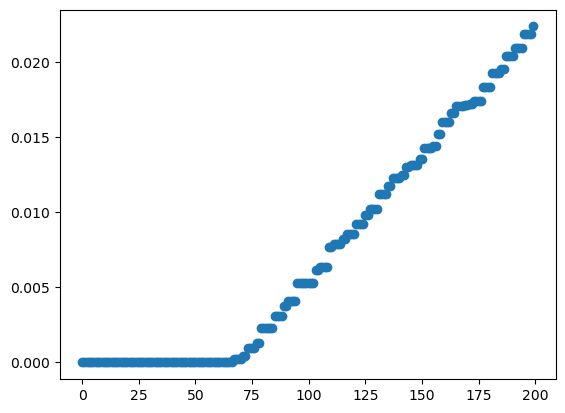

In [84]:
plt.scatter(range(len(energies)), np.sort(energies))

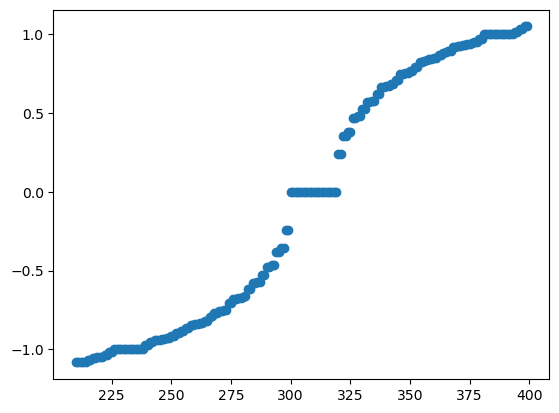

In [61]:
plt.scatter(range(210, 400), np.sort(energies)[210:400])

(array([10., 14., 12., 15., 11., 17., 16., 15., 16., 17., 21., 20., 26.,
        33., 23., 16.,  8.,  6.,  4.,  0., 20.,  0.,  4.,  6.,  8., 16.,
        23., 33., 26., 20., 21., 17., 16., 15., 16., 17., 11., 15., 12.,
        14., 10.]),
 array([-2.98056476, -2.83517136, -2.68977796, -2.54438455, -2.39899115,
        -2.25359775, -2.10820434, -1.96281094, -1.81741754, -1.67202414,
        -1.52663073, -1.38123733, -1.23584393, -1.09045052, -0.94505712,
        -0.79966372, -0.65427031, -0.50887691, -0.36348351, -0.2180901 ,
        -0.0726967 ,  0.0726967 ,  0.2180901 ,  0.36348351,  0.50887691,
         0.65427031,  0.79966372,  0.94505712,  1.09045052,  1.23584393,
         1.38123733,  1.52663073,  1.67202414,  1.81741754,  1.96281094,
         2.10820434,  2.25359775,  2.39899115,  2.54438455,  2.68977796,
         2.83517136,  2.98056476]),
 <BarContainer object of 41 artists>)

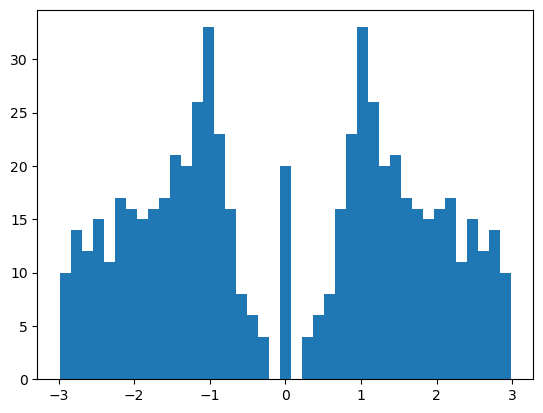

In [67]:
plt.hist(energies, bins=41)

In [11]:
class GQD:
    def __init__(self, r, a=1.0, shape = "c", start = 0.0, norb = 1, t_prime = 0.0):
        self.r = r
        self.a = a
        self.shape = shape
        self.norb = norb
        self.t_prime = t_prime
        self.system = None
        if shape.capitalize() == "C":
            self.system = create_graphene_circular_system(r, a = a, norb=norb, t_prime=t_prime)
        elif shape.capitalize() == "TZ" or shape.capitalize() == "T":
            self.system = create_graphene_tiangular_system(r, start = np.pi/2, t_prime=t_prime, a=a, norb=norb)
        elif shape.capitalize() == "TA":
            self.system = create_graphene_tiangular_system(r, start=start, t_prime=t_prime, a=a, norb=norb, type_="armchair")
        elif shape.capitalize() == "HZ" or shape.capitalize() == "H":
            self.system = create_graphene_hexagonal_system(r, start=0.0, t_prime=t_prime, a=a, norb=norb)
        elif shape.capitalize() == "HA":
            self.system = create_graphene_hexagonal_system(r, start=np.pi/6, t_prime=t_prime, a=a, norb=norb, type_="armchair")
        else:
            pass
        self.finalized_system = self.system.finalized()
        self.sites = list(self.system.sites())
        self.N = len(self.sites)

    def get_hamiltonian(self, sparse = True):
        self.H = self.finalized_system.hamiltonian_submatrix(sparse=True)
        
        return self.H
    
    def get_eigenstates(self):

        self.energies, eig_vecs = sla.eigsh(self.H, self.N-1)
        # self.eigenstates = eig_vecs.T
        argsort = np.argsort(self.energies)
        self.eigenstates = eig_vecs.T[argsort]
        self.energies = self.energies[argsort]
        return self.energies, self.eigenstates
        